##### Importing the necessary libraries

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import math
import torch
from datasets import load_dataset, DatasetDict
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig
from qwen_vl_utils import process_vision_info

# To report metrics to wandb (Optional)
from dotenv import load_dotenv
import wandb
load_dotenv()
wandb.login(key=os.getenv("WANDB_API_KEY"))

Skipping import of cpp extensions due to incompatible torch version 2.9.1+cu130 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
W1117 21:51:20.362000 6540 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Aaghaaz Khan\_netrc
wandb: Currently logged in as: aaghaazkhan12 (aaghaazkhan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##### Current VRAM usage: 210 MiB

In [2]:
!nvidia-smi

Mon Nov 17 21:51:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.80                 Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P5              4W /   75W |     210MiB /   6144MiB |     45%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### Loading the dataset

In [4]:
dataset = load_dataset("linxy/LaTeX_OCR", "human_handwrite")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1200
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 68
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 70
    })
})


The images in this dataset has the size of (<515, <=389) which is fine and won't make the GPU run into an OOM issue. 

Use the resize function according to your own need depending on your VRAM if need to resize the images.

In [5]:
# def resize_fn(sample):

#     img = sample['image']
#     width, height = img.size

#     if width <= 512 and height <= 512:
#         sample['image'] = img
#         return sample
    
#     scale = min(512/width, 512/height)
#     new_width = int(width * scale)
#     new_height = int(height * scale)
#     new_size = (new_width, new_height)
#     sample['image'] = img.resize(new_size)

#     return sample

# dataset = dataset.map(resize_fn)

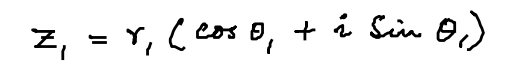

In [6]:
dataset['train'][0]['image']

In [7]:
dataset['train'][0]['text']

'z _ { 1 } = r _ { 1 } ( \\cos \\theta _ { 1 } + i \\sin \\theta _ { 1 } )'

##### Loading the model

In [8]:
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
processor = Qwen2_5_VLProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "right"

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [9]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    use_cache=False
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:19<00:00,  9.75s/it]


In [10]:
lora_config = LoraConfig(
    r=16, # the higher the rank, the better accuracy but could also lead to overfitting as well
    lora_alpha=32, # keep the value of alpha at least equal to the rank, or double of rank recommended
    lora_dropout=0, # set the dropout to 0.1 (recommended) if you notice overfitting during the training
    bias="none",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [11]:
PER_DEVICE_TRAIN_BATCH_SIZE = 2
PER_DEVICE_EVAL_BATCH_SIZE = 2        # Batch size = per_device_train_batch_size * gradient_accumulation_steps = 2*8 = 16
GRADIENT_ACCUMULATION_STEPS = 8
NUM_TRAIN_EPOCHS = 1

In [12]:
total_samples = len(dataset['train'])
steps_per_epoch = math.ceil(total_samples/(PER_DEVICE_TRAIN_BATCH_SIZE*GRADIENT_ACCUMULATION_STEPS))
total_steps = math.ceil(total_samples/(PER_DEVICE_TRAIN_BATCH_SIZE*GRADIENT_ACCUMULATION_STEPS))*NUM_TRAIN_EPOCHS

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total steps: {total_steps}")

Steps per epoch: 75
Total steps: 75


### Training

In [13]:
training_args = SFTConfig(
    output_dir="./output",
    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    gradient_checkpointing=True,
    learning_rate=2e-4,
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=5,
    save_strategy="no", # Enable saving checkpoints when training on cloud GPUs to stay on the safe side. I had to disabke it as i've trained locally and it caused issues while saving.
    # save_steps=25,
    # metric_for_best_model="eval_loss",
    # load_best_model_at_end=True,
    max_grad_norm=1,
    warmup_ratio=0.05,
    dataset_kwargs={"skip_prepare_dataset": True},
    max_length=256,
    remove_unused_columns=False,
    optim="paged_adamw_8bit",
    report_to="wandb",
    run_name="Qwen2_5_3B_VL_wnb",
    seed = 3407, # set a seed value for reproducibility 
    weight_decay = 0.01,
    lr_scheduler_type = "linear" # try experimenting with both "linear" and "cosine"
)

In [ ]:
def collate_fn(samples):
    user_prompt = "Convert the mathematical content in the image into LaTeX. Only output the LaTeX code no explanations or extra text."
    texts = []
    image_inputs = []

    for sample in samples:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": sample['image']},
                    {"type": "text", "text": user_prompt}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample['text']}
                ]
            }
        ]

        full_text = processor.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
        )

        processed_images = process_vision_info(messages)[0]

        texts.append(full_text)
        image_inputs.append(processed_images)

    inputs = processor(
        text=texts,
        images=image_inputs,
        return_tensors='pt',
        padding=True
    )

    labels = inputs['input_ids'].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    image_tokens = [151652, 151653, 151655]
    # image_tokens_id = processor.tokenizer.convert_tokens_to_ids(["<img>"])

    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100

    inputs['labels'] = labels

    return inputs

In [15]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset["validation"],
    data_collator=collate_fn,
    processing_class=processor,
)

In [16]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
5,3.773100,1.832597,1.888240,13953.000000,0.738746
10,1.005700,0.158812,1.965864,28770.000000,0.965996
15,0.087800,0.024705,1.780727,42847.000000,0.992448
20,0.051000,0.018388,1.629548,56605.000000,0.994410
25,0.028300,0.018239,1.533773,71601.000000,0.994088
30,0.019800,0.012281,1.473572,86151.000000,0.997154
35,0.017300,0.012362,1.426981,100675.000000,0.996958
40,0.027400,0.008420,1.416289,115412.000000,0.997757
45,0.025000,0.006735,1.423337,129576.000000,0.997975
50,0.026200,0.007382,1.433837,143724.000000,0.997989


##### Total VRAM used: 5.72 GiB

In [17]:
!nvidia-smi

Mon Nov 17 22:41:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.80                 Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   68C    P0             50W /   75W |    5861MiB /   6144MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
trainer.save_model(training_args.output_dir)
model.save_pretrained("qwen2_5_3B_VL_latex")
processor.save_pretrained("qwen2_5_3B_VL_latex")

[]

### Inference

In [19]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    use_cache=True
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.03s/it]


In [20]:
model.load_adapter('./output')

In [21]:
def text_generator(sample):

    user_prompt = "Convert the mathematical content in the image into LaTeX. Only output the LaTeX code no explanations or extra text."

    message = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": sample["image"]},
                {"type": "text", "text": user_prompt}
            ],
        }
    ]

    text = processor.apply_chat_template(
        message,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = processor(
        text=[text],
        images=[sample["image"]],
        return_tensors="pt"
    ).to(model.device)

    generated_ids = model.generate(**inputs, max_new_tokens=256)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
    )


    real_output = sample['text']
    generated_output = output[0]

    return generated_output, real_output

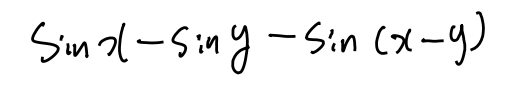

In [42]:
dataset['test'][25]['image']

In [43]:
generated_output, _ = text_generator(dataset["test"][25])
print(f"Fine-tuned model output: \n\n{generated_output}")

Fine-tuned model output: 

\sin x - \sin y - \sin \left( x - y \right)


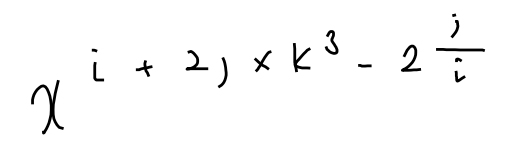

In [45]:
dataset['test'][48]['image']

In [47]:
generated_output, _ = text_generator(dataset["test"][48])
print(f"Fine-tuned model output: \n\n{generated_output}")

Fine-tuned model output: 

x ^ { i + 2 j \times k ^ { 3 } - 2 \frac { j } { i } }
